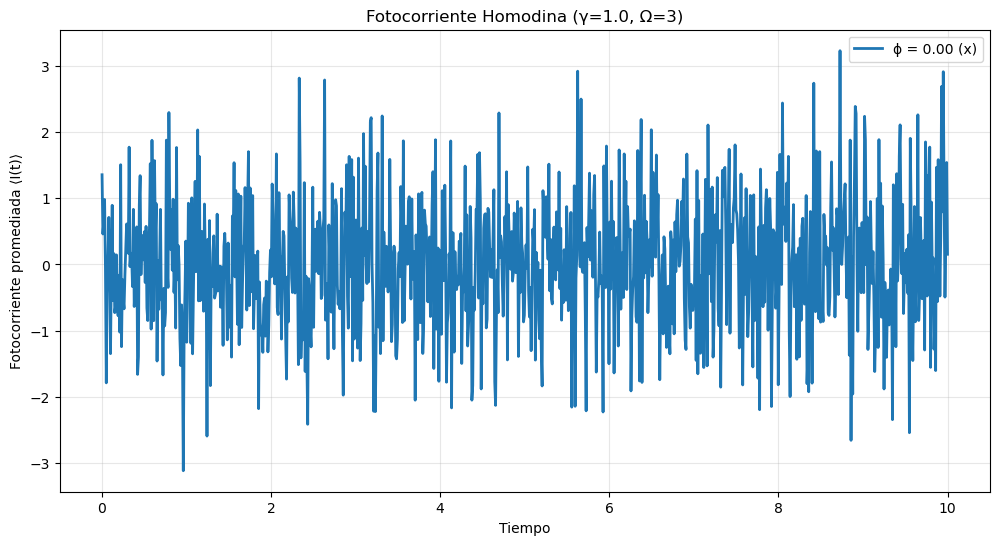

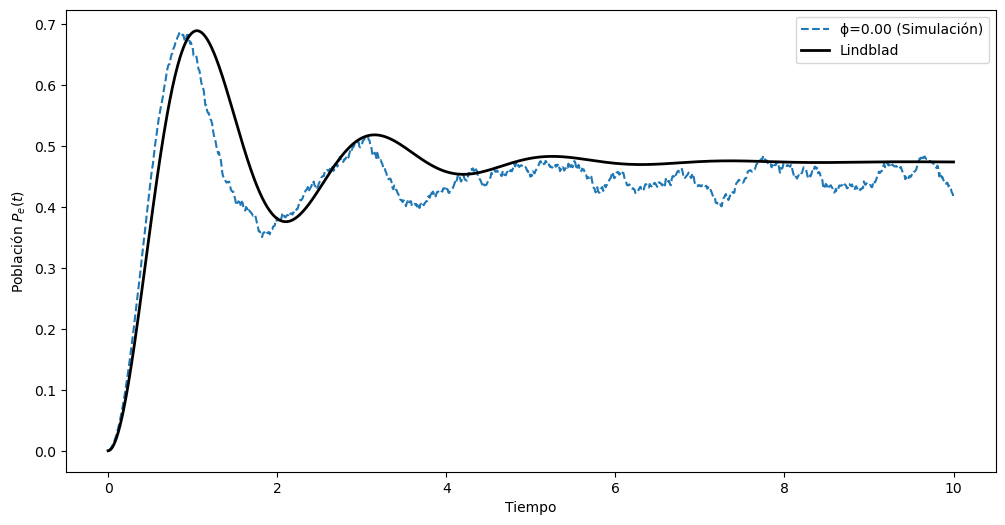

In [19]:
# Disipacion!
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# Parámetros
gamma = 1.0          # Tasa de detección
t_max = 10          # Tiempo de simulación
dt = 0.01            # Paso de tiempo
Omega = 3            # Frecuencia de Rabi
steps = int(t_max / dt)
Delta = 0.0          # Desintonía
num_traj = 100     # Número de trayectorias
phis = [0.0] # Fases a comparar

# Operadores cuánticos
sm = qt.destroy(2)    # σ-
sp = sm.dag()         # σ+
sigma_x = qt.sigmax() # Operador σ_x
sigma_y = qt.sigmay() # Operador σ_y
Pe = sp * sm          # Proyector |e⟩⟨e|

# Hamiltoniano del sistema (Rabi) CORREGIDO
H_sys = Delta * sp * sm + 0.5 * Omega * (sp + sm)

# Función para una trayectoria estocástica con fase ϕ
def simulate_trajectory(phi):
    dW = np.sqrt(dt) * np.random.randn(steps)  # Ruido de Wiener
    psi_t = qt.basis(2, 0).unit()              # Estado inicial |g⟩
    pop_exc = []                               # Población del estado excitado
    photocurrent = []                          # Fotocorriente para esta trayectoria
    
    # Operador σ_ϕ = σ_x cos(ϕ) + σ_y sin(ϕ)
    sigma_phi = np.cos(phi) * sigma_x + np.sin(phi) * sigma_y
    
    for i in range(steps):
        # Valor esperado de σ_ϕ
        sigma_phi_expect = qt.expect(sigma_phi, psi_t)
        
        # Fotocorriente: I(t) = √γ ⟨σ_ϕ⟩ + ξ(t) (ξ = dW/dt)
        I_t = np.sqrt(gamma) * sigma_phi_expect + dW[i] / dt
       

        photocurrent.append(I_t)
        
        # Término de retroalimentación (depende de ϕ)
        H_feedback = 1j * (2 * np.sqrt(gamma) * sigma_phi_expect + dW[i]/dt) * np.sqrt(gamma) * sm
        H_total = H_sys + H_feedback
        
        # Evolución del estado
        dpsi = (-1j * H_total * psi_t) * dt
        psi_t = (psi_t + dpsi).unit()
        pop_exc.append(qt.expect(Pe, psi_t))
    
    return pop_exc, photocurrent

# Simulación para ambas fases
results = {}
for phi in phis:
    # Arrays para almacenar resultados
    trajectories_pop = np.zeros((num_traj, steps))
    trajectories_I = np.zeros((num_traj, steps))
    
    for k in range(num_traj):
        pop, I = simulate_trajectory(phi)
        trajectories_pop[k, :] = pop
        trajectories_I[k, :] = I
        print(f"Fase ϕ={phi:.2f}: Trayectoria {k+1}/{num_traj}", end="\r")
    
    # Promedios
    avg_pop = np.mean(trajectories_pop, axis=0)
    avg_I = np.mean(trajectories_I, axis=0)
    
    results[phi] = {
        'avg_pop': avg_pop,
        'avg_I': avg_I,
        'trajectories_I': trajectories_I  # Opcional: guardar todas las trayectorias
    }

# Gráfico de fotocorrientes promediadas
plt.figure(figsize=(12, 6))
times = np.linspace(0, t_max, steps)

for phi in phis:
    label = f'ϕ = {phi:.2f} ({"x" if phi==0 else "y"})'
    plt.plot(times, results[phi]['avg_I'], label=label, linewidth=2)

plt.xlabel("Tiempo")
plt.ylabel("Fotocorriente promediada ⟨I(t)⟩")
plt.title(f"Fotocorriente Homodina (γ={gamma}, Ω={Omega})")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Opcional: Comparar con ecuación maestra para P_e(t)
plt.figure(figsize=(12, 6))
for phi in phis:
    plt.plot(times, results[phi]['avg_pop'], '--', label=f'ϕ={phi:.2f} (Simulación)')

# Ecuación maestra (solo una vez, pues no depende de ϕ)
c_ops = [np.sqrt(gamma) * sm]
rho0 = qt.ket2dm(qt.basis(2, 0))
result_me = qt.mesolve(H_sys, rho0, times, c_ops, [Pe])
plt.plot(times, result_me.expect[0], 'k-', label='Lindblad', linewidth=2)

plt.xlabel("Tiempo")
plt.ylabel("Población $P_e(t)$")
plt.legend()
plt.show()

In [70]:
Promediocuadratura = np.mean([results[0.0]['avg_pop'],results[1.5707963267948966]['avg_pop']], axis=0)

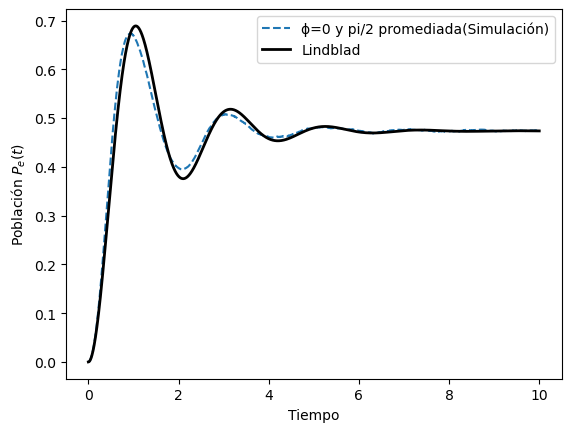

In [71]:
plt.plot(times, Promediocuadratura, '--', label='ϕ=0 y pi/2 promediada(Simulación)')
plt.plot(times, result_me.expect[0], 'k-', label='Lindblad', linewidth=2)

plt.xlabel("Tiempo")
plt.ylabel("Población $P_e(t)$")
plt.legend()
plt.show()

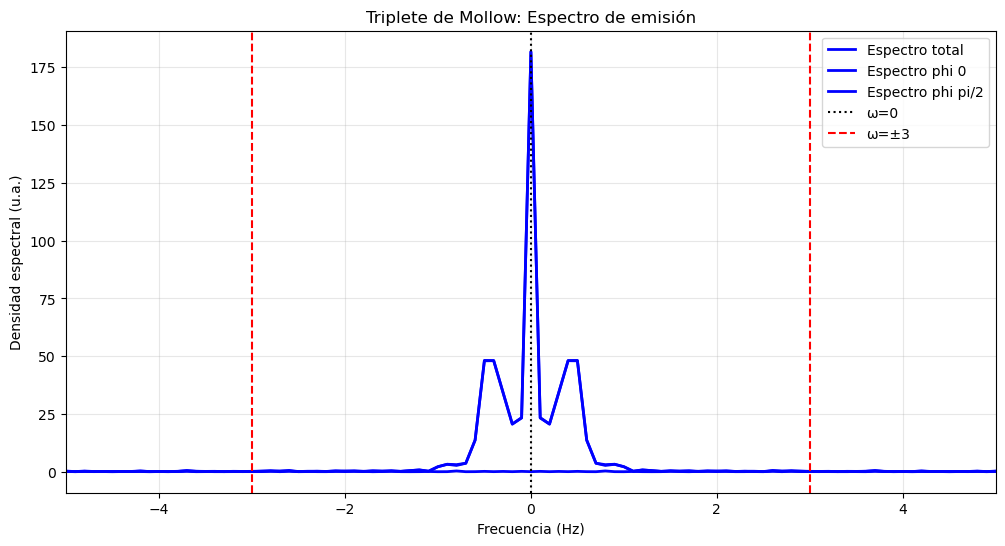

In [76]:
import numpy as np
from scipy.fft import fft, fftfreq, fftshift
import matplotlib.pyplot as plt

# 1. Obtener las fotocorrientes CORRECTAS (promedio de trayectorias)
I_phi0 = results[0]['avg_I']          # Fotocorriente para ϕ=0 (X)
I_phi_pi2 = results[np.pi/2]['avg_I'] # Fotocorriente para ϕ=π/2 (Y)

# 2. Parámetros clave para la FFT
           # Paso de tiempo (coherente con tu simulación)
fs = 1/dt            # Frecuencia de muestreo (25 Hz para dt=0.04)
n = len(I_phi0)      # Número de puntos

# 3. Calcular la FFT manualmente (para controlar frecuencias negativas)
def compute_fft(signal, dt):
    n = len(signal)
    fft_values = fft(signal, norm='ortho')  # FFT normalizada
    freqs = fftfreq(n, d=dt)                # Frecuencias (incluye negativas)
    return fftshift(freqs), fftshift(np.abs(fft_values)**2)  # Centrar en 0

# Espectro para cada cuadratura
freqs, Pxx_phi0 = compute_fft(I_phi0, dt)
_, Pxx_phi_pi2 = compute_fft(I_phi_pi2, dt)

# Espectro total (suma de energías)
Pxx_total = Pxx_phi0 + Pxx_phi_pi2

# 4. Filtrar frecuencias de interés (evitar ruido alto)
freq_mask = np.abs(freqs) <= 2*Omega  # Mostrar solo alrededor del triplete
freqs_filtered = freqs[freq_mask]

Pxx_total_filtered = Pxx_total[freq_mask]
P0_total_filtered = Pxx_phi0
Ppi_total_filtered = Pxx_phi_pi2

# 5. Gráfico del triplete de Mollow
plt.figure(figsize=(12, 6))
plt.plot(freqs_filtered, Pxx_total_filtered, 'b-', linewidth=2, label='Espectro total')
plt.plot(freqs, P0_total_filtered, 'b-', linewidth=2, label='Espectro phi 0')
plt.plot(freqs, Ppi_total_filtered, 'b-', linewidth=2, label='Espectro phi pi/2')
plt.axvline(x=0, color='k', linestyle=':', label='ω=0')
plt.axvline(x=Omega, color='r', linestyle='--', label=f'ω=±{Omega}')
plt.axvline(x=-Omega, color='r', linestyle='--')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Densidad espectral (u.a.)')
plt.title('Triplete de Mollow: Espectro de emisión')
plt.legend()
plt.grid(alpha=0.3)
plt.xlim(-5,5)
#plt.ylim(0,10)
plt.show()


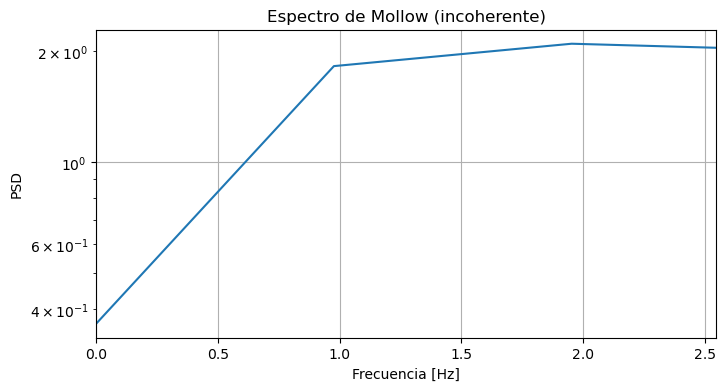

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

fs = 1/dt
ntraj = trajectories_I.shape[0]

# Acumular espectros
all_Pxx = []
for k in range(ntraj):
    I_k = trajectories_I[k]               # forma (steps,)
    I_kc = I_k - np.mean(I_k)             # centrar
    f, Pxx = welch(I_kc, fs=fs, nperseg=1024)
    all_Pxx.append(Pxx)

# Promediar
avg_Pxx = np.mean(all_Pxx, axis=0)

# Graficar
plt.figure(figsize=(8,4))
plt.semilogy(f, avg_Pxx)
plt.xlim(0, 2*Omega/(2*np.pi))  # hasta un poco más allá de los picos laterales
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD")
plt.title("Espectro de Mollow (incoherente)")
plt.grid(True)
plt.show()



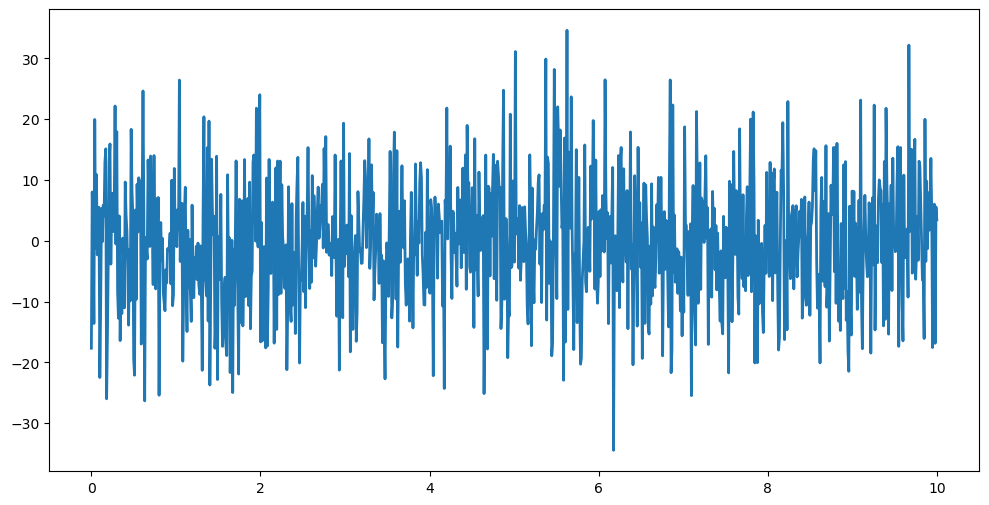

In [20]:

# Gráfico de fotocorrientes promediadas
plt.figure(figsize=(12, 6))
times = np.linspace(0, t_max, steps)

label = f'ϕ = {phi:.2f} ({"x" if phi==0 else "y"})'
plt.plot(times, trajectories_I[7], label=label, linewidth=2)